# exp057   
[Notion](https://www.notion.so/exp057-99a829982e6b47cdba5b739ff51e03c4?pvs=4)    
lsk: exp056, be: exp026を用いた場合のcvを算出する  
Copy from: exp032 <- exp028.ipynb <- exp025.ipynb <- exp021.ipynb <- exp018.ipynb <- exp012.ipynb  

In [1]:
import os
import random
import sys
import warnings
warnings.filterwarnings('ignore')
from collections import defaultdict
from typing import Tuple, Any, Dict, Optional

import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# リポジトリtopに移動
while os.path.basename(os.getcwd()) != 'rsna-2023':
    os.chdir('../')
    if os.getcwd() == '/':
        raise Exception('Could not find project root directory.')
    
from src.data_io import load_dicom_series
from src.segmentation.dataset import TestDataset as SegTestDataset
from src.segmentation.model import load_models as seg_load_models
from src.segmentation.trainer import inference as seg_inference
from src.classification.dataset import TestDatasetBowelExtra, TestDatasetSolidOrgans
from src.image_processing import apply_preprocess, crop_organ, kidney_split, resize_volume, apply_postprocess, kidney_specific, resize_3d, resize_1d
from src.classification.model import load_models as cls_load_models
from src.classification.trainer import inference as cls_inference
from src.metrics import score, create_training_solution, normalize_probabilities_to_one
from src.classification.dataset import load_df

# Configs

In [2]:
class CFG_INF:
    exp_name = 'exp_057'
    # evaluation時：'train', submission時：'test'
    phase = 'train'
    base_dir = 'data/rsna-2023-abdominal-trauma-detection'
    image_dir = f'data/rsna-2023-abdominal-trauma-detection/{phase}_images'
    # dataframeはこのconfigにもたせ、phaseで対応できるようにする.
    if phase == 'train':
        df = pd.read_csv(os.path.join(base_dir, 'train.csv'))
    elif phase == 'test':
        df = pd.read_csv(os.path.join(base_dir, 'sample_submission.csv'))
    df_series_meta = pd.read_csv(os.path.join(base_dir, f'{phase}_series_meta.csv'))
    image_size = (512, 512)
    # sample submissionで極端にスライス数が少ない場合があるため対応.
    min_slices = 10
    # 推論時間制限のため
    max_slices = 500
    max_series = 2
    model_save_dir = "outputs"
    lsk_model_mode = 'final'
    be_model_mode = 'final'

class CFG_LSK:
    exp_name = 'exp_056'
    # model config
    # timm backbone
    backbone = 'efficientnet-b4'
    n_ch = 1
    expand_ch_dim = True
    # n_class: healthy, low, high
    n_class = 3
    # hyper params
    ww = 1000
    wl = 0
    init_lr = 5e-4
    min_lr = 1e-6
    weight_decay = 1e-4
    image_size = (128, 128, 160)
    batch_size = 32
    amp = False
    eps = 1e-8
    n_epoch = 20
    pretrain = True
    freeze_epochs = 0
    noaug_epochs = 1
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset002"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 4
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    class_weight=torch.tensor([1.0, 1.0, 1.0]).to(device)

class CFG_BE:
    exp_name = 'exp_026'
    # model config
    # timm backbone
    backbone = 'efficientnet_b4'
    # n_ch: z軸方向のスライス数
    n_ch = 5
    expand_ch_dim = False
    # n_class: bowel_injury, extravasation
    # sample weighted: 4class
    n_class = 4
    label_smoothing = None #Optional(float)
    # hyper params
    ww = 1000
    wl = 0
    init_lr = 5e-5
    min_lr = 1e-6
    weight_decay = 1e-4
    image_size = (512, 512)
    batch_size = 64
    amp = True
    eps = 1e-7
    n_epoch = 18
    iteration_per_epoch = 100
    pretrain = True
    freeze_epochs = 1
    noaug_epochs = 2
    # fold config
    n_fold = 6
    include_evaluation = False
    train_folds = 1
    # path
    image_dir = "data/dataset001"
    model_save_dir = "outputs"
    # other config
    seed = 42
    num_workers = 4
    num_gpus = 2
    progress_bar = True
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # b_healty, b_injury, e_healty, e_injury
    class_weight=torch.tensor([1.0, 2.0, 1.0, 6.0]).to(device)

In [3]:
# organs dict (for SEG and LSK models)
organ_index_dict_inv = {
    0: 'liver',
    1: 'spleen',
    2: 'kidney',
    3: 'bowel'
}
organ_index_dict = {v: k for k, v in organ_index_dict_inv.items()}

# labels dict (for BE models)
label_index_dict_inv = {
    0: 'bowel',
    1: 'extravasation'
}

In [4]:
def load_series_from_dataset(dir_: str, max_slices: Optional[int]=None)-> np.ndarray:
    """seriesを読み込む."""
    path_list = os.listdir(dir_)
    path_list = [[int(path.replace(".npy","")), path] for path in path_list]
    path_list.sort()
    path_list = [path[1] for path in path_list]
    if max_slices is not None:
        step = (len(path_list) + max_slices - 1) // max_slices
        path_list = path_list[::step]
    arr = []
    for path in path_list:
        arr.append(np.load(os.path.join(dir_, path)))
    return np.array(arr)

def load_image(path: str) -> np.ndarray:
    """画像の読み込み.
    Args:
        path (str): 画像のパス.
    Returns:
        numpy.ndarray: 画像.
    Note:
        現在読み込む画像の形式は.png, .npy, .npzのみ対応.
        cv2.IMREAD_UNCHANGED: 16bit画像やアルファチャンネルを考慮した読み込み.
    """
    if path.endswith(".png"):
        image = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    elif path.endswith(".npy"):
        image = np.load(path)
    elif path.endswith(".npz"):
        image = np.load(path)["arr_0"]
    else:
        raise Exception(f"unexpected image format: {path}")
    return image

In [5]:
class Inference:
    """推論パイプライン."""
    def __init__(self,CFG_INF: Any, CFG_LSK: Any, CFG_BE: Any):
        self.CFG_INF = CFG_INF
        self.CFG_LSK = CFG_LSK
        self.CFG_BE = CFG_BE
        
        self.lsk_models = cls_load_models(CFG_LSK, mode=self.CFG_INF.lsk_model_mode)
        self.be_models = cls_load_models(CFG_BE, mode=self.CFG_INF.be_model_mode, framework="timm")
    
    def __call__(self, pid: int) -> tuple:
        """inference process.
        1. load images from dicom files.
        2. create segmentation masks.
        3. create liver, spleen, kidney volumes.
        4. inference lsk models.
        5. inference be models.
        Args:
            pid (int): patient id.
        Return example:
            dict: {
            'pid': 0,
            'bowel_healthy': 0.0,
            'bowel_injury': 0.0,
            'extravasation_healthy': 0.0,
            'extravasation_injury': 0.0,
            'kidney_healthy': 0.0,
            'kidney_low': 0.0,
            'kidney_high': 0.0,
            'liver_healthy': 0.0,
            'liver_low': 0.0,
            'liver_high': 0.0,
            'spleen_healthy': 0.0,
            'spleen_low': 0.0,
            'spleen_high': 0.0
            }
        Note:
            - １症例に複数シリーズ存在する場合、各シリーズに対して推論を行い、全予測結果の最大値を採用する.
            - 推論時間的に厳しければ、最初のシリーズのみを採用するなど検討.
        """
        df_study = self.CFG_INF.df_series_meta[self.CFG_INF.df_series_meta['patient_id']==pid].reset_index(drop=True)
        # df_study内のそれぞれのシリーズを取得して、画像枚数に対して降順にソート.
        df_study = self.get_slices_and_sort(df_study)
        preds = defaultdict(list)
        for sid in df_study['series_id'].to_list()[:self.CFG_INF.max_series]:
            data = self.load_data(pid, sid)
            if data is None:
                continue
            lsk_preds = self.lsk_prediction(pid, sid)
            be_preds = self.be_prediction(data)
            for idx, organ in organ_index_dict_inv.items():
                if idx == 3:
                    continue
                preds[organ].append(lsk_preds[idx])
            for idx, label in label_index_dict_inv.items():
                pred = np.array([be_preds[idx]])
                preds[label].append(pred)

        ret = {'patient_id': pid}
        for k,v in preds.items():
            v = np.array(v)
            ret[k] = np.max(v, axis=0)
        ret = self.convert_submission_format(ret)
        return ret

    def load_data(self, pid: int, sid: int)-> np.ndarray:
        """dicomから画像を読み込む.
        Args:
            pid (int): patient id.
            sid (int): series id.
        Returns:
            np.ndarray: (Z, H, W) normalized CT series.
        Note:
            - preprocessは全モデル共通なので、ここで行う.
            - H, Wはすべてself.CFG_INF.image_sizeにresizeされる.
        """
        series_path = os.path.join(self.CFG_BE.image_dir, 'train_images', str(pid), str(sid))
        # sample submissionでこういう例が存在する.
        if not os.path.exists(series_path):  
            return None
        image_arr = load_series_from_dataset(series_path, self.CFG_INF.max_slices)
        image_arr = apply_preprocess(image_arr, resize=self.CFG_INF.image_size)
        # sample submission対応
        if len(image_arr) < self.CFG_INF.min_slices:
            image_arr = resize_1d(image_arr, self.CFG_INF.min_slices, axis=0)
        return image_arr
    
    def get_slices_and_sort(self, df_study: pd.DataFrame)-> pd.DataFrame:
        """シリーズのスライス数を取得して、スライス数に対して降順にソートする.
        Args:
            df_study (pd.DataFrame): series meta dataframe.
        Returns:
            pd.DataFrame: sorted series meta dataframe.
        """
        pid = df_study['patient_id'][0]
        df_study['n_slices'] = 0
        for i in range(len(df_study)):
            sid = df_study['series_id'][i]
            series_path = os.path.join(self.CFG_INF.image_dir, str(pid), str(sid))
            if os.path.exists(series_path):
                df_study['n_slices'][i] = len(os.listdir(series_path))
        df_study = df_study.sort_values(by='n_slices', ascending=False)
        return df_study
    
    def lsk_prediction(self, pid: int, sid: int)-> np.ndarray:
        """liver, spleen, kidneyの予測値を返す.
        Args:
            pid: patient id
            sid: series id
        Returns:
            np.ndarray: (organs, grades).
        """
        volumes = self.get_lsk_volumes(pid, sid) # (organs, z, h, w)
        volumes = apply_preprocess(volumes, wl=self.CFG_LSK.wl, ww=self.CFG_LSK.ww)
        lsk_iterator = self.pseudo_iterator(self.CFG_LSK, volumes)
        pred = cls_inference(self.CFG_LSK, self.lsk_models, lsk_iterator)
        return pred

    def get_lsk_volumes(self, pid: int, sid: int)->Dict[str, np.ndarray]:
        """Segmentationからliver, spleen, kidneyのvolume dataを作成.
        Args:
            pid: patient id
            sid: series id
        Returns:
            np.ndarray: (organs, z, h, w).
        Note:
            - organsはliver, spleen, kidneyの順番.
            - この関数内でCFG.LSK.image_sizeのreshapeまで行う.
            - 腎臓は左右を分離してからくっつけ直すという特殊な処理が必要.
        """
        arr = []
        for idx, organ in organ_index_dict_inv.items():
            if idx == 3:
                continue
            path = os.path.join(self.CFG_LSK.image_dir, str(pid), str(sid), f"{organ}.npy")
            if organ == "kidney":
                # 解剖学的な左右を、画像上の左右に置き換えて読み込み
                l, r = (
                    path.replace("kidney.npy", "kidney_r.npy"),
                    path.replace("kidney.npy", "kidney_l.npy"),
                )
                if os.path.exists(l):
                    l = load_image(l)
                else:
                    l = np.zeros(self.CFG_LSK.image_size)
                if os.path.exists(r):
                    r = load_image(r)
                else:
                    r = np.zeros(self.CFG_LSK.image_size)
                img_cropped = kidney_specific(self.CFG_LSK, l, r)
            else:
                organ_segment = load_image(path)
                img_cropped = resize_3d(organ_segment, self.CFG_LSK.image_size)
                
            arr.append(img_cropped)
        arr = np.stack(arr, axis=0)
        return arr
    
    def be_prediction(self, data: np.ndarray)-> np.ndarray:
        """bowel_injury及びextravasation_injuryの予測を行う.
        Args:
            data: (Z, H, W).
        Returns:
            np.ndarray: [bowel_injury_pred, extravasation_injury_pred].
            example: [0.1, 0.9].
        """
        be_iterator = self.pseudo_iterator(self.CFG_BE, data)
        pred = cls_inference(self.CFG_BE, self.be_models, be_iterator)
        pred = self.be_prediction_postprocess(pred)
        return pred
    
    def be_prediction_postprocess(self, pred: np.ndarray)-> np.ndarray:
        """スライスごとの予測をシリーズの予測に変換する.
        Args:
            pred: (len(data),['bowel_injury', 'extravasation_injury']).
        Returns:
            np.ndarray: ['bowel_injury', 'extravasation_injury'].
        Note:
            - 予測値の最大値から外れ値を考慮した2%percentileを採用する.
        """
        if self.CFG_BE.n_class == 1:
            bowel = np.zeros_like(pred[:, 0])
            extravasation = pred[:, 0]
        elif self.CFG_BE.n_class == 2:
            bowel = pred[:, 0]
            extravasation = pred[:, 1]
        elif self.CFG_BE.n_class == 4:
            bowel = normalize_probabilities_to_one(pred[:, :2])
            extravasation = normalize_probabilities_to_one(pred[:, 2:])
            bowel = bowel[:, 1]
            extravasation = extravasation[:, 1]
        
        p = 98
        bowel = np.percentile(bowel, p)
        extravasation = np.percentile(extravasation, p)
        return np.array([bowel, extravasation])

    def pseudo_iterator(self, CFG: Any, images: np.ndarray)-> tuple:
        """evaluation iterator.
        Args:
            CFG: config.
            images: (batch dim, H, W) or (batch dim, Z, H, W).
        """
        batch = CFG.batch_size
        length = len(images)
        arr = []
        if not CFG.expand_ch_dim:
            images = self.add_dummy_array(CFG, images)
        for i in range(length):
            if CFG.expand_ch_dim:
                img = images[i]
                img = img[np.newaxis, ...]
            else:
                img = images[i:i+CFG.n_ch]
            arr.append(img)
            if i != 0 and (i%batch==0 or i == length-1):
                arr = np.stack(arr, axis=0)
                arr = torch.from_numpy(arr.astype(arr.dtype, copy=False))
                yield arr
                arr = []

    def add_dummy_array(self, CFG: Any, images: np.ndarray)-> np.ndarray:
        """chが複数ある場合に、事前に0配列を追加しておく."""
        add_ch = CFG.n_ch//2
        arr = []
        img = np.zeros_like(images[0])
        for i in range(add_ch):
            arr.append(img)
        arr.extend(images)
        for i in range(add_ch):
            arr.append(img)
        arr = np.stack(arr, axis=0)
        return arr
    
    def convert_submission_format(self, pred: dict)->dict:
        """提出形式に変換する."""
        converted = dict()
        for idx, organ in organ_index_dict_inv.items():
            if idx == 3:
                continue
            for idx, grade in enumerate(['healthy', 'low', 'high']):
                converted[f'{organ}_{grade}'] = pred[organ][idx]
        for idx, label in label_index_dict_inv.items():
            converted[f'{label}_healthy'] = 1 - pred[label][0]
            converted[f'{label}_injury'] = pred[label][0]

        converted['patient_id'] = pred['patient_id']
        return converted

In [6]:
df_solid_organ = load_df(CFG_LSK)
# fold 0のpatient_idを取得
pids = df_solid_organ[df_solid_organ["fold"] == 0]["patient_id"].unique()
df_all = pd.read_csv(os.path.join(CFG_INF.base_dir, 'train.csv'))
train_pids = df_solid_organ[df_solid_organ["fold"] != 0]["patient_id"].unique()
valid_pids = df_solid_organ[df_solid_organ["fold"] == 0]["patient_id"].unique()
df_train = df_all[df_all["patient_id"].isin(train_pids)].reset_index(drop=True)
df_valid = df_all[df_all["patient_id"].isin(valid_pids)].reset_index(drop=True)

In [7]:
inference_instance = Inference(CFG_INF, CFG_LSK, CFG_BE)

In [8]:
results = []
for pid in tqdm(df_valid['patient_id'].to_list()):
    result = inference_instance(pid)
    results.append(result)

100%|██████████| 525/525 [33:52<00:00,  3.87s/it]


In [15]:
extravasation = []
for i in results:
    extravasation.append(i["extravasation_injury"])

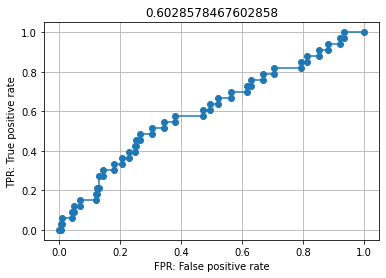

In [16]:
from sklearn.metrics import roc_auc_score, roc_curve
x = np.array(extravasation)
y = df_valid["extravasation_injury"]
fpr, tpr, thresholds = roc_curve(y, x)
auc = roc_auc_score(y, x)
plt.plot(fpr, tpr, marker='o')
plt.title(auc)
plt.xlabel('FPR: False positive rate')
plt.ylabel('TPR: True positive rate')
plt.grid()

In [17]:
import pickle
# resultsを保存
dir_ = os.path.join(CFG_INF.model_save_dir, CFG_INF.exp_name)
os.makedirs(dir_, exist_ok=True)
path = os.path.join(dir_, "results_seg004_lsk055_be026.pkl")
# with open(path, 'wb') as f:
#    pickle.dump(results, f)

# resultsを読み込み
with open(path, 'rb') as f:
   results = pickle.load(f)

In [20]:
pd.DataFrame(results)[:10]

,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high,kidney_healthy,kidney_low,kidney_high,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,patient_id
0,0.956367,0.039518,0.007648,0.966071,0.031871,0.005242,0.986136,0.013111,0.001359,0.816518,0.183482,0.947678,0.052322,10007
1,0.960000,0.037186,0.006847,0.968840,0.029129,0.004682,0.969926,0.027211,0.004346,0.779929,0.220071,0.946795,0.053205,10205
2,0.986022,0.024402,0.003625,0.956604,0.102004,0.037002,0.986566,0.013668,0.001456,0.956565,0.043435,0.965257,0.034743,10275
3,0.861548,0.159454,0.095484,0.942492,0.051236,0.012646,0.936626,0.055789,0.014358,0.956799,0.043201,0.844909,0.155091,10430
4,0.976180,0.022267,0.003095,0.949677,0.043361,0.009187,0.474337,0.252168,0.273709,0.816477,0.183523,0.916104,0.083896,10494
5,0.986279,0.012471,0.001287,0.962978,0.034657,0.005993,0.982838,0.016038,0.001869,0.900557,0.099443,0.975557,0.024443,10696
6,0.972280,0.025973,0.003895,0.947597,0.047442,0.009998,0.971803,0.026485,0.003978,0.781205,0.218795,0.863249,0.136751,10987
7,0.735931,0.171892,0.102648,0.660834,0.201816,0.147574,0.970040,0.027829,0.004386,0.939824,0.060176,0.980086,0.019914,11130
8,0.985200,0.047233,0.009809,0.990381,0.016631,0.001992,0.983758,0.041121,0.007898,0.848319,0.151681,0.964305,0.035695,11139
9,0.986423,0.013280,0.001394,0.982104,0.024652,0.003601,0.379310,0.311938,0.487664,0.855507,0.144493,0.916214,0.083786,11378


In [8]:
submission = pd.DataFrame(results)
order = CFG_INF.df.columns.tolist()
if "any_injury" in order:
    order.remove("any_injury")
submission = submission[order]

In [9]:
def metric_hack(df:pd.DataFrame)->pd.DataFrame:
    """bowel, liver, spleen, kidney.いずれかが高い予測値を持つとき、extravasationも合併している確率が高い."""
    cols = ["liver_low", "liver_high", "spleen_low", "spleen_high", "kidney_low", "kidney_high"]
    # "extravasation_injury", "bowel_injury", 
    df["extravasation_injury"] = df[cols].max(axis=1)
    df["extravasation_healthy"] = 1 - df["extravasation_injury"]
    return df
# submission = metric_hack(submission)

In [10]:
"""def min_scaling(submission: pd.DataFrame)->pd.DataFrame:
    cols = ["bowel_injury", "extravasation_injury", "kidney_low", "kidney_high", "liver_low", "liver_high", "spleen_low", "spleen_high"]
    for col in cols:
        train_mean = df_train[col].mean()
        submission[col] = submission[col].apply(lambda x: max(x, train_mean))
    return submission
submission = min_scaling(submission)"""

'def min_scaling(submission: pd.DataFrame)->pd.DataFrame:\n    cols = ["bowel_injury", "extravasation_injury", "kidney_low", "kidney_high", "liver_low", "liver_high", "spleen_low", "spleen_high"]\n    for col in cols:\n        train_mean = df_train[col].mean()\n        submission[col] = submission[col].apply(lambda x: max(x, train_mean))\n    return submission\nsubmission = min_scaling(submission)'

In [11]:
submission

,patient_id,bowel_healthy,bowel_injury,extravasation_healthy,extravasation_injury,kidney_healthy,kidney_low,kidney_high,liver_healthy,liver_low,liver_high,spleen_healthy,spleen_low,spleen_high
0,10007,0.816518,0.183482,0.947678,0.052322,0.986136,0.013111,0.001359,0.956367,0.039518,0.007648,0.966071,0.031871,0.005242
1,10205,0.779929,0.220071,0.946795,0.053205,0.969926,0.027211,0.004346,0.960000,0.037186,0.006847,0.968840,0.029129,0.004682
2,10275,0.956565,0.043435,0.965257,0.034743,0.986566,0.013668,0.001456,0.986022,0.024402,0.003625,0.956604,0.102004,0.037002
3,10430,0.956799,0.043201,0.844909,0.155091,0.936626,0.055789,0.014358,0.861548,0.159454,0.095484,0.942492,0.051236,0.012646
4,10494,0.816477,0.183523,0.916104,0.083896,0.474337,0.252168,0.273709,0.976180,0.022267,0.003095,0.949677,0.043361,0.009187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,9537,0.917280,0.082720,0.993776,0.006224,0.986805,0.012417,0.001250,0.974162,0.024204,0.003522,0.985181,0.014182,0.001530
521,96,0.877808,0.122192,0.984195,0.015805,0.980418,0.018186,0.002294,0.972843,0.025549,0.003804,0.964415,0.032899,0.005657
522,9620,0.929224,0.070776,0.950181,0.049819,0.837667,0.123726,0.051508,0.965716,0.031751,0.005370,0.957716,0.038731,0.007323
523,9835,0.951448,0.048552,0.971621,0.028379,0.983276,0.074145,0.020594,0.891724,0.151112,0.084896,0.919549,0.086864,0.028615


In [12]:
# add weight
solution_train = create_training_solution(df_valid)

no_scale_score = score(solution_train.copy(),submission.copy(),'patient_id')
print(f'Training score without scaling: {no_scale_score:.4f}')

bowel: 0.1935
extravasation: 0.8347
kidney: 0.3538
liver: 0.5705
spleen: 0.5667
any_injury: 0.9103
mean: 0.5716
Training score without scaling: 0.5716


In [16]:
# Group by different sample weights
scale_by_1 = ['bowel_injury']
scale_by_2 = ['kidney_low','liver_low','spleen_low']
scale_by_4 = ['kidney_high','liver_high','spleen_high']
scale_by_6 = ['extravasation_injury']

# Scale factors based on described metric 
sf_1 = 0.3
sf_2 = 2
sf_4 = 4
sf_6 = 6

# Reset the prediction
y_pred = submission.copy()

# Scale each target 
y_pred[scale_by_1] *=sf_1
y_pred[scale_by_2] *=sf_2
y_pred[scale_by_4] *=sf_4
y_pred[scale_by_6] *=sf_6

weight_scale_score = score(solution_train.copy(),y_pred.copy(),'patient_id')
print(f'Training score with weight scaling: {weight_scale_score:.4f}')

bowel: 0.1478
extravasation: 0.5560
kidney: 0.3421
liver: 0.5652
spleen: 0.5550
any_injury: 0.5759
mean: 0.4570
Training score with weight scaling: 0.4570


In [17]:
# Group by different sample weights
scale_by_1 = ['bowel_injury']
scale_by_2 = ['kidney_low','liver_low','spleen_low']
scale_by_4 = ['kidney_high','liver_high','spleen_high']
scale_by_6 = ['extravasation_injury']

# Scale factors based on described metric 
sf_1 = 0.3
sf_2 = 2
sf_4 = 4
sf_6 = 4

# Reset the prediction
y_pred = submission.copy()

# Scale each target 
y_pred[scale_by_1] *=sf_1
y_pred[scale_by_2] *=sf_2
y_pred[scale_by_4] *=sf_4
y_pred[scale_by_6] *=sf_6

weight_scale_score = score(solution_train.copy(),y_pred.copy(),'patient_id')
print(f'Training score with weight scaling: {weight_scale_score:.4f}')

bowel: 0.1478
extravasation: 0.5048
kidney: 0.3421
liver: 0.5652
spleen: 0.5550
any_injury: 0.6413
mean: 0.4594
Training score with weight scaling: 0.4594
